### Predicting House Sale Prices with a linear regression model

We'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. We can read more about why the data was collected [here](https://doi.org/10.1080/10691898.2011.11889627). We can also read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

In [1]:
#load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv('AmesHousing.tsv', sep = '\t')
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

### Transform features

In [4]:
# Remove columns that don't provide information
cols = ['Order', 'PID']
data = data.drop(cols, axis = 1) 

In [5]:
# Remove categorical data with one or more missing values
categ_cols = data.select_dtypes(include = 'object').isnull().sum().sort_values(ascending = False)
categ_missing_values = categ_cols[categ_cols > 0]
data = data.drop(categ_missing_values.index, axis=1)
categ_missing_values

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Fireplace Qu      1422
Garage Cond        159
Garage Qual        159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
BsmtFin Type 1      80
Bsmt Qual           80
Bsmt Cond           80
Mas Vnr Type        23
Electrical           1
dtype: int64

In [6]:
# Remove columns with more that 5% missing values 
count_null = data.isnull().sum()
columns_to_remove = count_null[count_null > len(data) /20].index
data = data.drop(columns_to_remove, axis = 1)

In [7]:
# Fill in missing values contain less than 5% missing values using 
# the mean value of that column
data = data.fillna(data.mean())

In [8]:
# Create new features related to dates
data['Years_Before_Sale'] = data['Yr Sold'] - data['Year Built']
data['Years_Since_Remod'] = data['Yr Sold'] - data['Year Remod/Add']
data = data.drop(['Yr Sold', 'Year Built', 'Year Remod/Add'], axis=1)

### Exploratory Data Analysis

In [9]:
# Correlation
num_features = data.select_dtypes(include = ['int', 'float']).columns
corr_coeffs = data[num_features].corr()
corr_coeffs


,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,SalePrice,Years_Before_Sale,Years_Since_Remod
MS SubClass,1.000000,-0.204613,0.039419,-0.067349,0.002724,-0.060067,-0.070937,-0.130404,-0.219416,-0.247828,...,-0.014823,-0.022866,-0.037956,-0.050614,-0.003434,-0.029254,0.000350,-0.085092,-0.037302,-0.044530
Lot Area,-0.204613,1.000000,0.097188,-0.034759,0.126586,0.191546,0.083145,0.023657,0.253576,0.332235,...,0.103760,0.021868,0.016243,0.055044,0.093775,0.069188,0.003859,0.266549,-0.024227,-0.023141
Overall Qual,0.039419,0.097188,1.000000,-0.094812,0.427470,0.284011,-0.041272,0.269956,0.547088,0.477837,...,0.298412,-0.140332,0.018240,0.041615,0.030399,0.005179,0.031103,0.799262,-0.597021,-0.570956
Overall Cond,-0.067349,-0.034759,-0.094812,1.000000,-0.135088,-0.050920,0.041122,-0.136780,-0.173295,-0.157052,...,-0.068934,0.071459,0.043852,0.044055,-0.016787,0.034056,-0.007295,-0.101697,0.369570,-0.045714
Mas Vnr Area,0.002724,0.126586,0.427470,-0.135088,1.000000,0.300396,-0.016007,0.091210,0.395438,0.393666,...,0.142766,-0.110447,0.013778,0.065622,0.004617,0.044932,-0.000275,0.505784,-0.312122,-0.197299
BsmtFin SF 1,-0.060067,0.191546,0.284011,-0.050920,0.300396,1.000000,-0.054129,-0.477875,0.536547,0.457437,...,0.124937,-0.100453,0.050541,0.095873,0.084140,0.092886,-0.001155,0.432794,-0.278438,-0.150317
BsmtFin SF 2,-0.070937,0.083145,-0.041272,0.041122,-0.016007,-0.054129,1.000000,-0.238617,0.089958,0.084644,...,-0.005587,0.032379,-0.023325,0.062950,0.044398,-0.005204,-0.009483,0.005890,0.027679,0.062553
Bsmt Unf SF,-0.130404,0.023657,0.269956,-0.136780,0.091210,-0.477875,-0.238617,1.000000,0.411726,0.295929,...,0.118870,0.006229,-0.005446,-0.048082,-0.031999,-0.010166,0.021566,0.182805,-0.130368,-0.167037
Total Bsmt SF,-0.219416,0.253576,0.547088,-0.173295,0.395438,0.536547,0.089958,0.411726,1.000000,0.800659,...,0.245606,-0.085223,0.037871,0.075340,0.072128,0.083904,0.016676,0.632105,-0.407311,-0.298021
1st Flr SF,-0.247828,0.332235,0.477837,-0.157052,0.393666,0.457437,0.084644,0.295929,0.800659,1.000000,...,0.238041,-0.065713,0.044061,0.098316,0.121821,0.093003,0.040496,0.621676,-0.310585,-0.242987


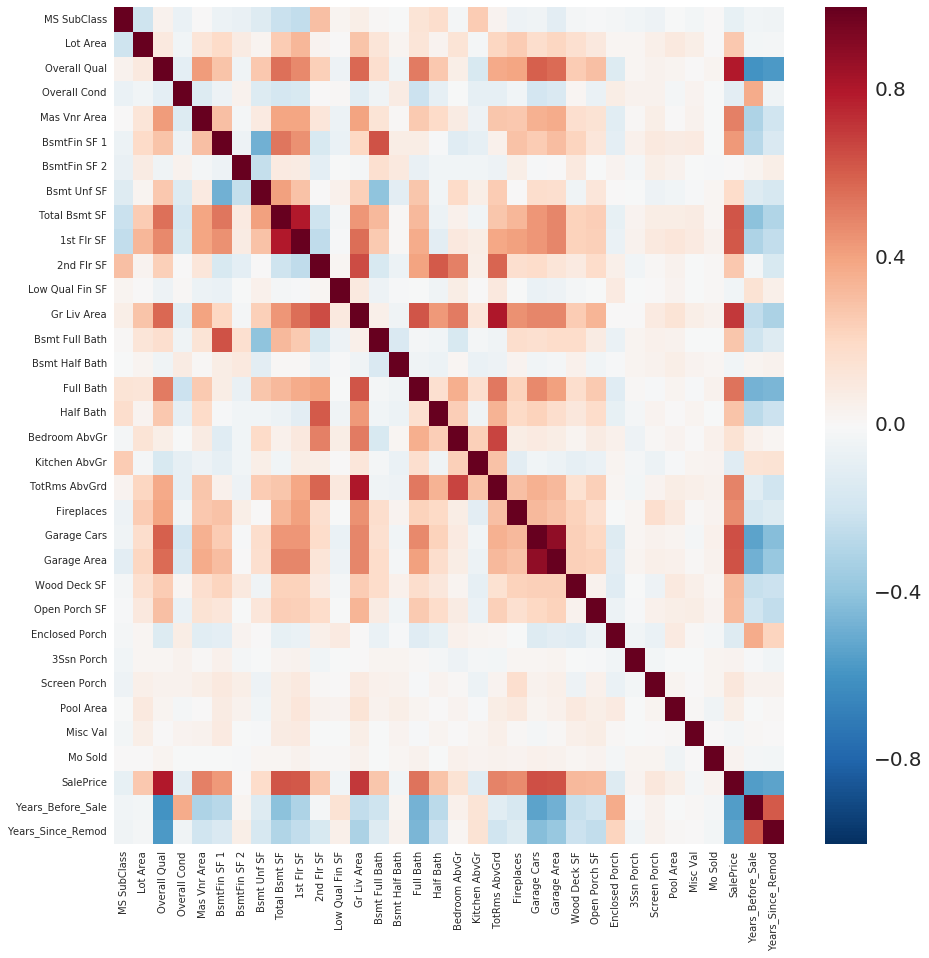

In [10]:
# Plot correlations
plt.subplots(figsize=(15,15))
sns.set(font_scale=2.0)
sns.heatmap(corr_coeffs);

In [11]:
# Select numeric features with high correlation with 'SalePrice', greater than 0.6
corr_coeffs = data[num_features].corr()['SalePrice'].abs().sort_values(ascending = False)
corr_coeffs

SalePrice            1.000000
Overall Qual         0.799262
Gr Liv Area          0.706780
Garage Cars          0.647861
Garage Area          0.640385
Total Bsmt SF        0.632105
1st Flr SF           0.621676
Years_Before_Sale    0.558907
Full Bath            0.545604
Years_Since_Remod    0.534940
Mas Vnr Area         0.505784
TotRms AbvGrd        0.495474
Fireplaces           0.474558
BsmtFin SF 1         0.432794
Wood Deck SF         0.327143
Open Porch SF        0.312951
Half Bath            0.285056
Bsmt Full Bath       0.275894
2nd Flr SF           0.269373
Lot Area             0.266549
Bsmt Unf SF          0.182805
Bedroom AbvGr        0.143913
Enclosed Porch       0.128787
Kitchen AbvGr        0.119814
Screen Porch         0.112151
Overall Cond         0.101697
MS SubClass          0.085092
Pool Area            0.068403
Low Qual Fin SF      0.037660
Bsmt Half Bath       0.035815
Mo Sold              0.035259
3Ssn Porch           0.032225
Misc Val             0.015691
BsmtFin SF

In [12]:
high_corr = corr_coeffs[corr_coeffs > 0.6]
high_corr

SalePrice        1.000000
Overall Qual     0.799262
Gr Liv Area      0.706780
Garage Cars      0.647861
Garage Area      0.640385
Total Bsmt SF    0.632105
1st Flr SF       0.621676
Name: SalePrice, dtype: float64

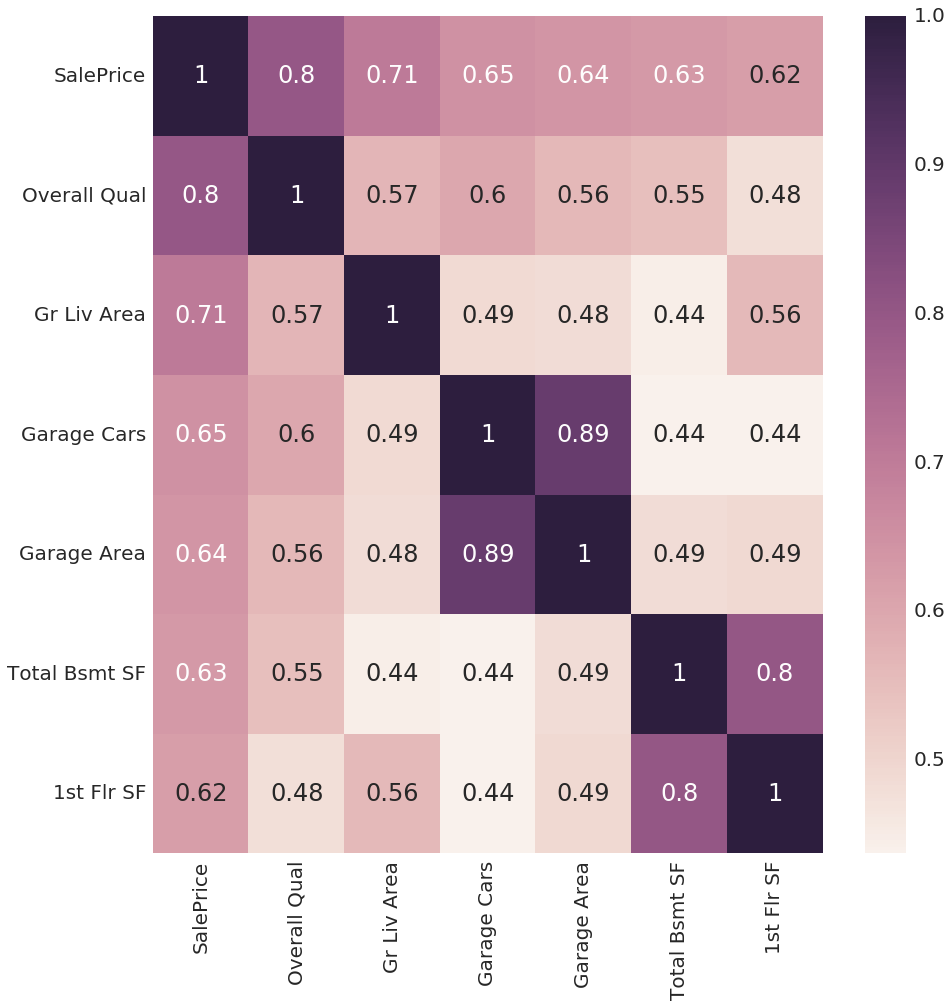

In [13]:
# Correlation between variables
between_corr = data[high_corr.index].corr()
plt.subplots(figsize=(15,15))
sns.set(font_scale=2.0)
sns.heatmap(between_corr, annot = True);

We can see 'Garage Cars' and 'Garage Area' are highly correlated 0.89. We´ll remove 'Garage Area' because is lower correlated with 'SalePrice'.
The same with 'Total Bsmt SF' and '1st Flr SF' with a correlation of 0.80, we´ll remove '1st Flr SF' because is lower correlated with 'SalePrice'.

In [14]:
# Numerical features selected
features = ['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF']

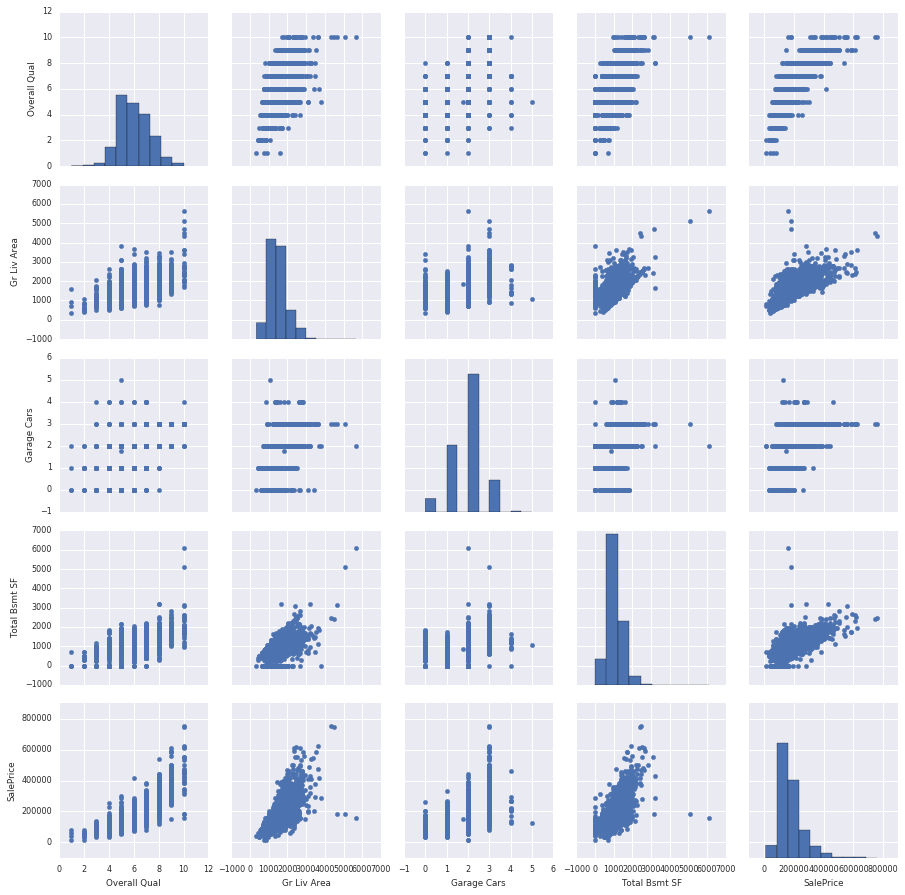

In [15]:
# Plot numerical features selected
num_features = ['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', 'SalePrice']
sns.set(font_scale=0.8)
graph = sns.PairGrid(data[num_features])
graph .map_diag(plt.hist)
graph.map_offdiag(plt.scatter);


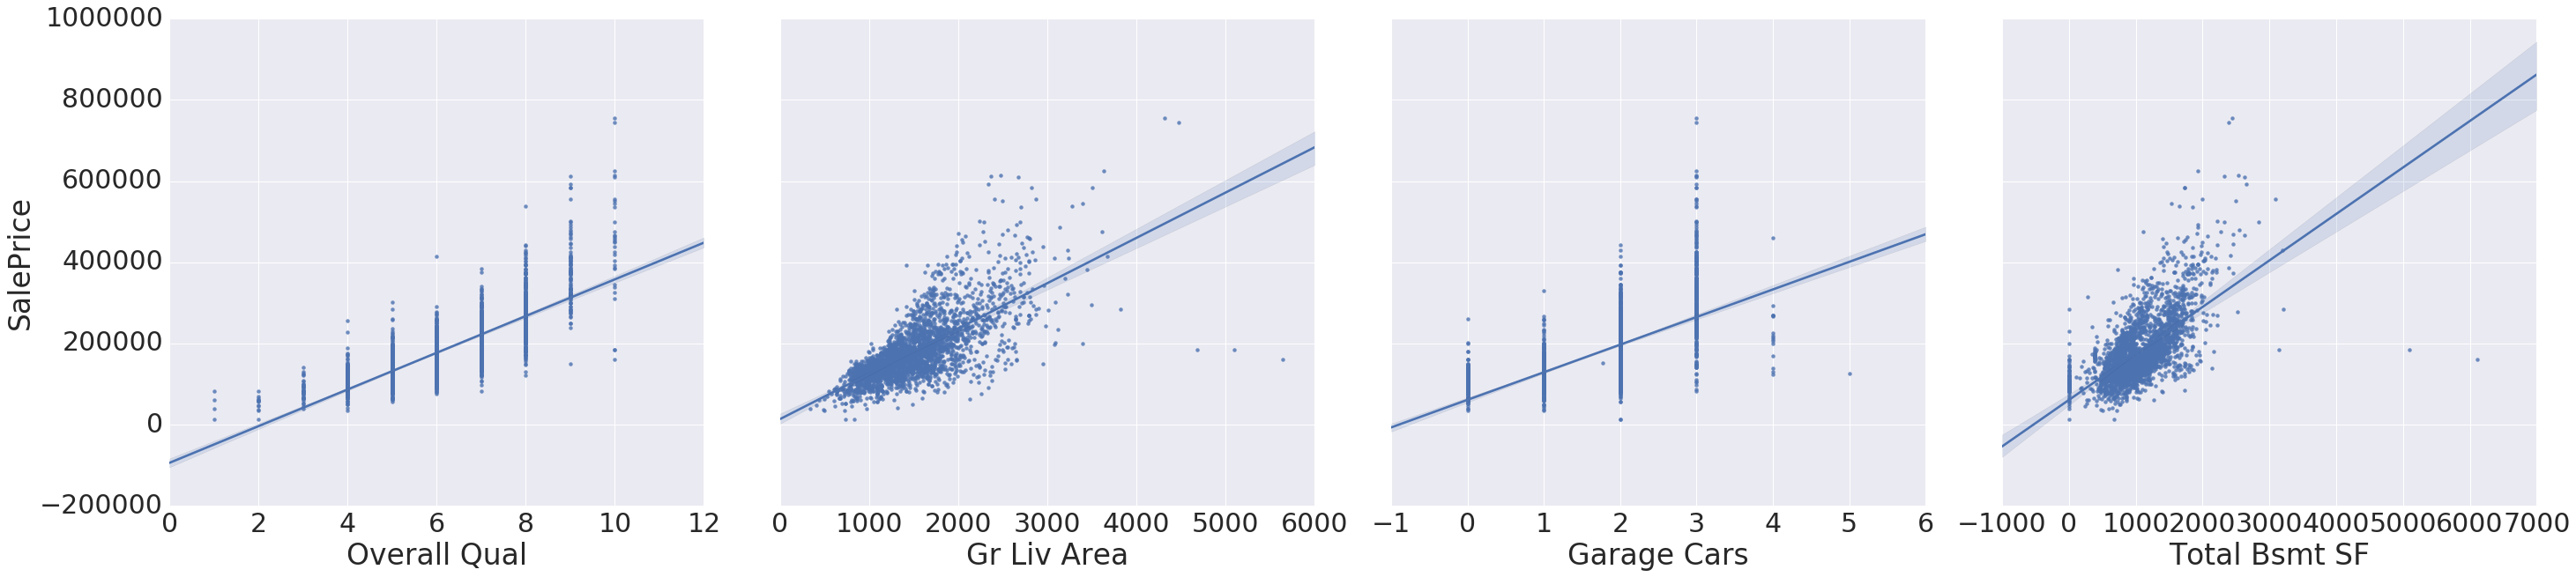

In [16]:
sns.set(font_scale = 3.0)
sns.pairplot(data, x_vars = features,
            y_vars = ['SalePrice'], size=10, aspect = 1, kind = 'reg');

### Linear regression model applied

#### Test with only selected numerical features and split data into two halves, one to train and other to validate.

In [17]:
def train_and_test(data, features):
    train  = data[0:1460]
    test = data[1460:]
    
    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    prediction = lr.predict(test[features])
    test_mse = mean_squared_error(test['SalePrice'], prediction)
    test_rmse = np.sqrt(test_mse)                                       
    return test_rmse

In [18]:
rmse = train_and_test(data, features)
print(rmse)

41530.56878998007


#### Test with only selected numerical features and K-Folds Cross Validation.

In [19]:
def train_and_test2(data, features, k):
    kf = KFold(n_splits=k, shuffle=True)
    lr = LinearRegression()
    rmse_values = []
    for train_index, test_index, in kf.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)
        rmse_values.append(rmse)
    print(rmse_values)
    avg_rmse = np.mean(rmse_values)
    return avg_rmse

In [20]:
rmse = train_and_test2(data, features, 4)
print(rmse)

[35324.446348199264, 32061.63350998272, 43489.56496693348, 39673.3287948324]
37637.24340498696


#### Iterate over categorial features and select best one for the model

In [21]:
def train_and_test3(data, features, k):
    all_features = ['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', 'SalePrice']
    features = ['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF']
    d_aux = data[all_features]
    category_features = data.select_dtypes(include = 'object').columns
    dict_avg_rmse = {}
    for category in category_features:
        col_dummy = pd.get_dummies(data[category])
        df = pd.concat([d_aux, col_dummy], axis = 1)
        features_aux = df.columns.drop('SalePrice') 
        
        kf = KFold(n_splits=k, shuffle=True)
        lr = LinearRegression()
        rmse_values = []
        
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features_aux], train["SalePrice"])
            predictions = lr.predict(test[features_aux])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
            avg_rmse = np.mean(rmse_values)
        dict_avg_rmse[category] = avg_rmse
    return dict_avg_rmse

In [22]:
avg_rmse = train_and_test3(data, features, 4)
print(avg_rmse)

{'Roof Style': 37263.98707280443, 'Utilities': 37659.07518494141, 'Heating QC': 37497.164899846284, 'House Style': 37251.485857126085, 'Central Air': 37718.14603790222, 'Kitchen Qual': 35355.51302347556, 'Exter Cond': 37643.88024874609, 'Sale Condition': 37109.98403947853, 'Bldg Type': 37146.38400366278, 'Lot Config': 37744.209840476455, 'MS Zoning': 37449.36968256643, 'Functional': 37570.09988787776, 'Exterior 1st': 37918.15404362844, 'Exterior 2nd': 37520.56349058224, 'Sale Type': 37260.49458708673, 'Land Slope': 37832.041515908575, 'Exter Qual': 36001.07816305199, 'Paved Drive': 38112.24993557997, 'Condition 2': 38752.5236279375, 'Condition 1': 38154.996647558626, 'Roof Matl': 38367.29498084332, 'Street': 38010.68791853708, 'Land Contour': 37187.127211157866, 'Lot Shape': 37880.67225492681, 'Neighborhood': 34298.60005375958, 'Heating': 37857.69709286946, 'Foundation': 37286.290964340995}


In [23]:
# Categorical feature with the minimum avg rmse
min_avg_rmse = min(avg_rmse, key=avg_rmse.get)
min_avg_rmse, avg_rmse[min_avg_rmse]

('Neighborhood', 34298.60005375958)